# Loading data and preprocessing

In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Load the data
path = 'data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/'
data = {f: pd.read_csv(path + f + '.csv') for f in ['campaign_desc', 'campaign_table',
                                                    'causal_data', 'coupon', 'coupon_redempt',
                                                    'hh_demographic', 'product',
                                                    'transaction_data']}

## Merge transactions set with other metadata

In [4]:
transactions = data["transaction_data"]\
                .merge(data["hh_demographic"], on="household_key", how="left")\
                .merge(data["product"], on="PRODUCT_ID", how="left")

## Compute some time based features

In [24]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [25]:
# Analyze weekday distribution
transactions.groupby("WEEK_NO")["DAY"].unique()

WEEK_NO
1                          [1, 2, 3, 4, 5]
2                 [6, 7, 8, 9, 10, 11, 12]
3             [13, 14, 15, 16, 17, 18, 19]
4             [20, 21, 22, 23, 24, 25, 26]
5             [27, 28, 29, 30, 31, 32, 33]
                      ...                 
98     [678, 679, 680, 681, 682, 683, 684]
99     [685, 686, 687, 688, 689, 690, 691]
100    [692, 693, 694, 695, 696, 697, 698]
101    [699, 700, 701, 702, 703, 704, 705]
102         [706, 707, 708, 709, 710, 711]
Name: DAY, Length: 102, dtype: object

We can see that first and last week are underrepresented, so we will drop them. The second week starts at 6 so we will devise this to be 1st day of the week.

Unfortunately we cannot exactly say which day is which weekday, 1st day can be Monday or Sunday based on two most common weekday numbering schemes.

In further analyses we have seen bigger sales on two last days of the week so we hypothesize this is the weekend (so that would mean first day is Monday) - this will be explained in a further section.

In [26]:
transactions["DAY_OF_WEEK"] = (transactions["DAY"] - 6) % 7 + 1

In [27]:
transactions["HOUR"] = np.floor(transactions.TRANS_TIME / 100).apply(int)

In [37]:
# We look at a random sample of the time features we generated to make sure they look ok
transactions[["HOUR", "DAY_OF_WEEK", "WEEK_NO", "DAY", "MONTH"]].sample(5)

,HOUR,DAY_OF_WEEK,WEEK_NO,DAY,MONTH
1003693,13,5,46,318,11
1037778,18,6,47,326,11
258953,18,3,19,127,5
1336060,21,4,58,401,14
1049072,15,1,48,328,11


## Create a demographic and product dataframe

In [32]:
missing_demographic = 100 * transactions.HOMEOWNER_DESC.isna().sum() / transactions.shape[0]
print(f"{missing_demographic}% of transactions doesn't have demographic data")

45.01346826251709% of transactions doesn't have demographic data


Since some transactions are missing demographic data, we create a dataframe that contains only transactions with demographic data for demographic analysis, and a second dataframe without these columns for other tasks.

In [33]:
transactions_demographic = transactions.dropna()

In [34]:
transactions_products = transactions.dropna(axis=1)

In [35]:
transactions_demographic.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
11,1364,26984896261,1,842930,1,2.19,31742,0.00,1520,1,...,None/Unknown,69,GROCERY,Private,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,10 OZ,1,3,15
12,1364,26984896261,1,897044,1,2.99,31742,-0.40,1520,1,...,None/Unknown,1075,GROCERY,National,CRACKERS/MISC BKD FD,SNACK CRACKERS,9.5 OZ,1,3,15
13,1364,26984896261,1,920955,1,3.09,31742,0.00,1520,1,...,None/Unknown,3664,MEAT,National,BEEF,GRND/PATTY - ROUND,,1,3,15
14,1364,26984896261,1,937406,1,2.50,31742,-0.99,1520,1,...,None/Unknown,2209,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW,12OZ,1,3,15
15,1364,26984896261,1,981760,1,0.60,31742,-0.79,1520,1,...,None/Unknown,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,1,3,15


In [36]:
transactions_products.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,COUPON_MATCH_DISC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,MONTH,DAY_OF_WEEK,HOUR
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,1,3,16
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,1,3,16
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,0.0,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,,1,3,16
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,0.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,1,3,16
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,0.0,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,1,3,16


# Question 1: Shopping trends over time

In [41]:
from sklearn.linear_model import LinearRegression

In [59]:
def plot_trend(x, y, xlabel, ylabel, title, std=None):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    if std is not None:
        plt.fill_between(monthly.index, monthly - std, monthly + std, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [43]:
# we compute mean 
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum().groupby("WEEK_NO").mean().sort_index()

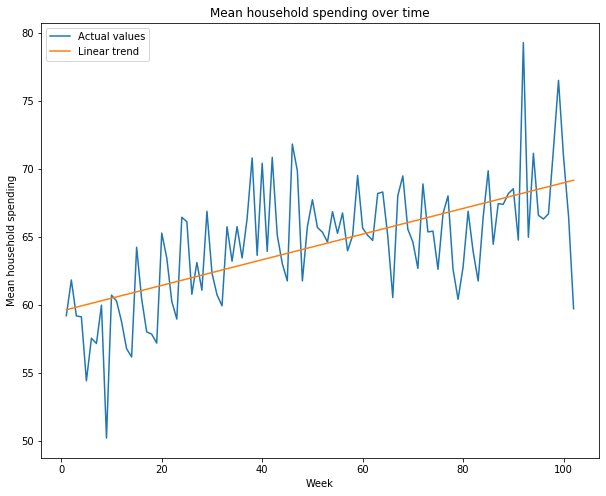

In [60]:
plot_trend(weekly.index, weekly, "Week", "Mean household spending", "Mean household spending over time")

There is a high deviation between subsequent weeks but we can see that the sales are overall increasing over time. The linear regression shows a rising tendency.

The big drop in the last week is most likely caused by the fact that this week is underrepresented (it doesn't contain the last day).

In [45]:
# Now we compute mean household spending in each month

In [64]:
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

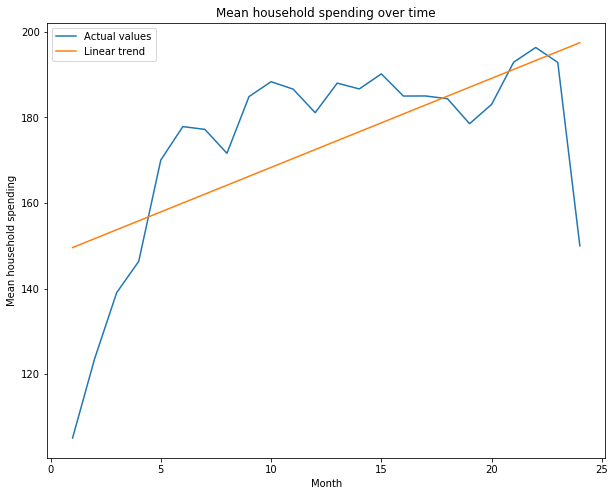

In [65]:
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

In [66]:
transactions.groupby("MONTH")["DAY"].unique().apply(len)

MONTH
1     29
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
12    30
13    30
14    30
15    30
16    30
17    30
18    30
19    30
20    30
21    30
22    30
23    30
24    22
Name: DAY, dtype: int64

As we can see, due to our approximation last month contains less days than the other, so it is underrepresented. That explains the big drop at the end.

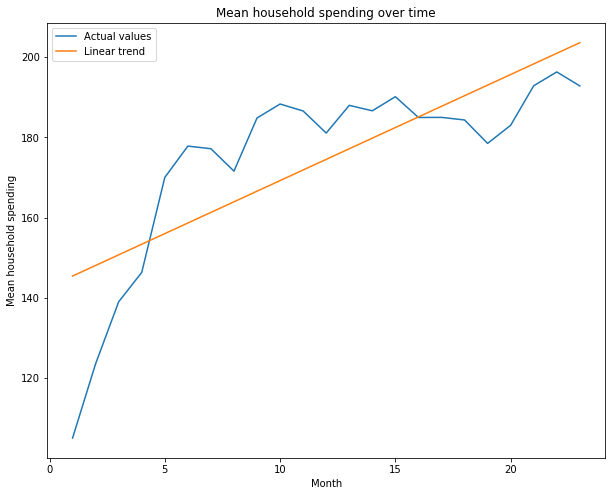

In [72]:
monthly = monthly[monthly.index < 24]
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

So we remove the last underrepresented month. The sales are clearly increasing over time and the linear trend is highly increasing.

We hypothesize there could be 2 factors accounting for the increase:
- people are generally spending more money on shopping over time
- due to advertising campaigns, people more often choose the store we have data for and they do a bigger part of their shopping there than before (so it's possible they spend the same amount overall, just the place where they spend the money has changed)
    
Most likely both of these factors are at play here. We could analyse the efficiency of advertising to understand that better.

### Trends in various categories

In [74]:
def analyze_categories(data, category_column, statistic_computation, sort=True, show_separate=False, filter_too_small_threshold=None):
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))
    
    if show_separate:
        for cat, stat in zip(values, stats):
            if filter_too_small_threshold is not None and stat.sum() < filter_too_small_threshold:
                continue
            print(cat)
            plot_trend(stat.index, stat, "", "", cat)
    
    skipped = 0
    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):
        if filter_too_small_threshold is not None and stat.sum() < filter_too_small_threshold:
                skipped += 1
                continue
        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    #plt.xlabel("TODO")
    plt.title("Comparison over " + category_column)
    plt.legend()
    plt.show()
    print(f"Skipped {skipped} categories which were below threshold")

In [75]:
def stat_mean_monthly_spending(data):
    return data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().groupby("MONTH").mean()

### Brand

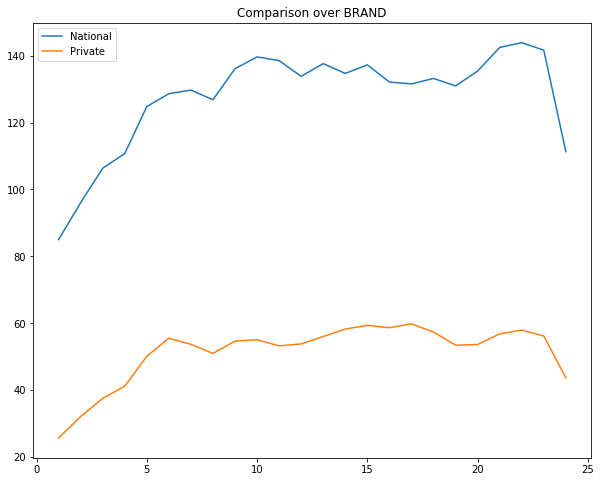

Skipped 0 categories which were below threshold


In [103]:
analyze_categories(transactions_products, "BRAND", stat_mean_monthly_spending)

#### Age

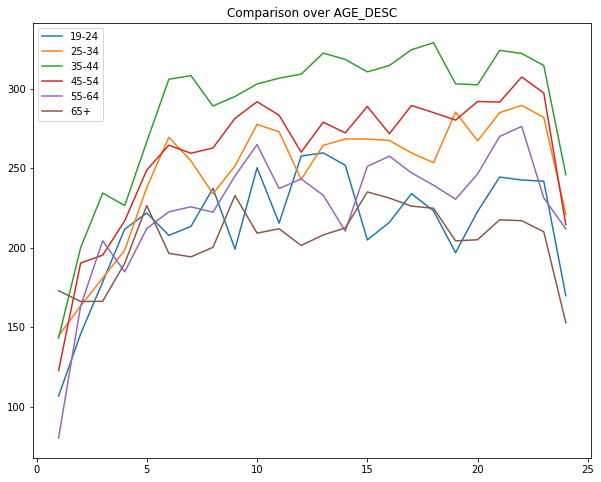

Skipped 0 categories which were below threshold


In [76]:
analyze_categories(transactions_demographic, "AGE_DESC", stat_mean_monthly_spending)

We can see that older (65+) and young (<24) people generally tend to buy less than other groups and middle aged people buy more - probably because students and elderly often live alone and adults around 30-40 are likely to be shopping for their whole family.

#### Income

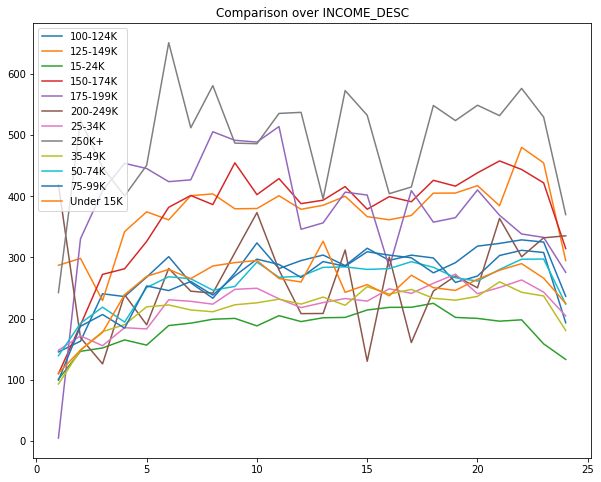

Skipped 0 categories which were below threshold


In [79]:
analyze_categories(transactions_demographic, "INCOME_DESC", stat_mean_monthly_spending)

In [84]:
def monthly_spending(data):
    return data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

In [85]:
rich = monthly_spending(transactions_demographic[transactions_demographic.INCOME_DESC == "250K+"])

In [86]:
rest = monthly_spending(transactions_demographic[transactions_demographic.INCOME_DESC != "250K+"])

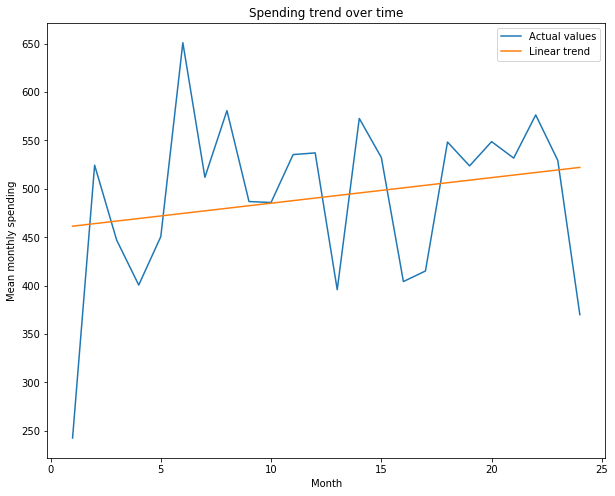

In [89]:
plot_trend(rich.index, rich, "Month", "Mean monthly spending", "Spending trend over time")

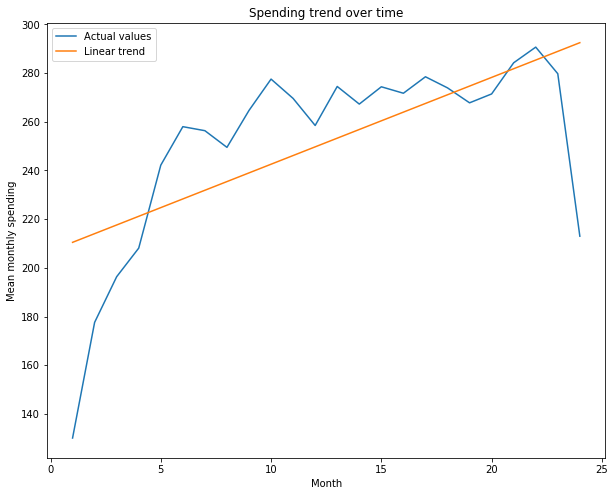

In [90]:
plot_trend(rest.index, rest, "Month", "Mean monthly spending", "Spending trend over time")

We can see that rich people are spending more at a slower late then people making less.

In [94]:
overall = transactions_demographic.groupby("household_key")["SALES_VALUE"].sum().rename("overall_spending")

In [95]:
def stat_relative_monthly_spending(data):
    merged = data.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().merge(overall, on="household_key")
    merged["relative_spending"] = merged["SALES_VALUE"] / merged["overall_spending"] * 100
    return merged.groupby("MONTH")["relative_spending"].mean()

In [96]:
rich = stat_relative_monthly_spending(transactions_demographic[transactions_demographic.INCOME_DESC == "250K+"])

In [98]:
rest = stat_relative_monthly_spending(transactions_demographic[transactions_demographic.INCOME_DESC != "250K+"])

Looking at relativized plots (indicating % of overall spending of a household in each month), we can see the rich group is mostly spending steadily and other people are spending more.

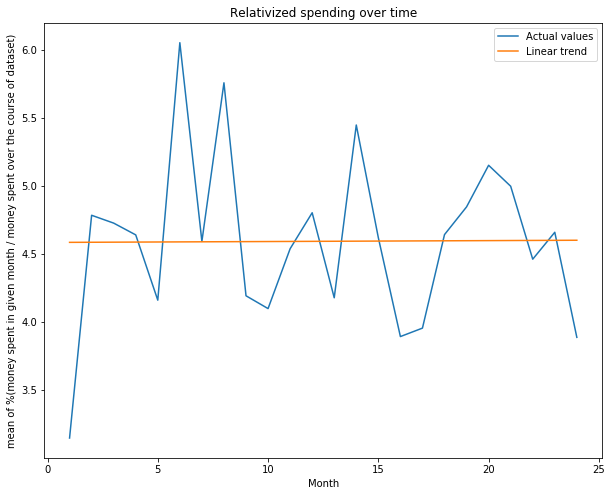

In [101]:
plot_trend(rich.index, rich, "Month", "mean of %(money spent in given month / money spent over the course of dataset)", "Relativized spending over time")

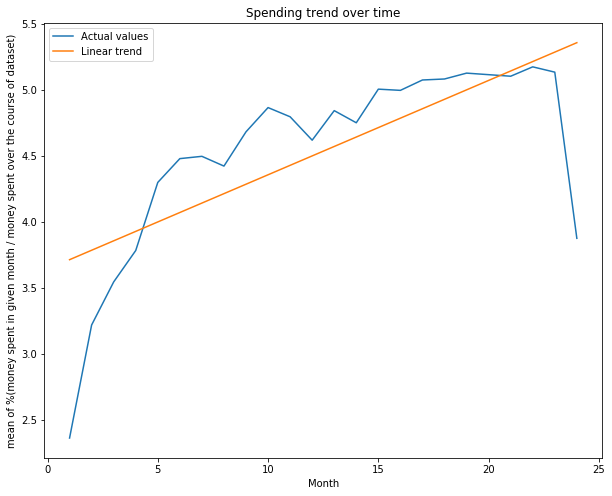

In [102]:
plot_trend(rest.index, rest, "Month", "mean of %(money spent in given month / money spent over the course of dataset)", "Spending trend over time")

## Spending on days of week

In [105]:
dow = transactions.groupby(["household_key", "DAY_OF_WEEK"])["SALES_VALUE"].sum().groupby("DAY_OF_WEEK").mean()

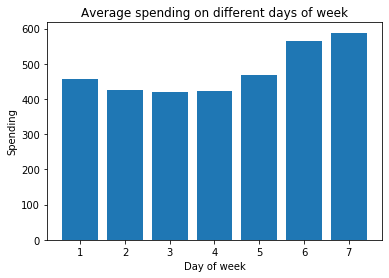

In [106]:
plt.bar(dow.index, dow)
plt.title("Average spending on different days of week")
plt.xlabel("Day of week")
plt.ylabel("Spending")
plt.show()

It is only a hypothesis, but it seems that 1 = Monday indeed, as the last two days get higher spendings and people tend to go shopping on the weekends (at least in countries when most shops are open on Sundays, but if this shop was closed altogether it would have 0 sales or small sales in only specific shopping points, which would be clear from the plot).

So we can conjecture that 1 = Monday, 7 = Sunday and people do most sales on the weekend (which seems reasonable as they have more time) and also a bit more than usual on Friday (after work, maybe in preparation for the weekend) and Mondays (maybe to refill after a weekend).



## Correlations

In [110]:

def stat_overall_monthly_quantity(data):
    return data.groupby(["MONTH"])["QUANTITY"].sum()

(We skip gasoline as it's quantity is in mililiters and it dominates all sales when looking at quantitym)

In the future we might do feature engineering and compute a "normalized" quantity - normal for other products and set to 1 for gasoline, or just divided by 1000 to get liters which is more in line with other units.

<Figure size 1440x1080 with 0 Axes>

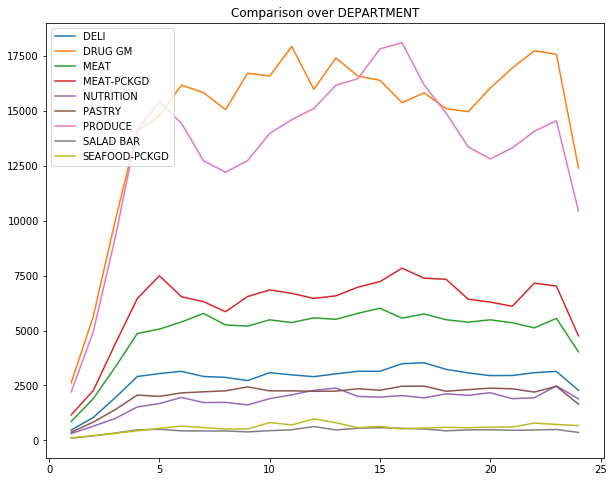

Skipped 33 categories which were below threshold


In [113]:
plt.figure(figsize=(20,15))
analyze_categories(
    transactions[(transactions.DEPARTMENT != "GROCERY") & (transactions.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")], 
    "DEPARTMENT",
    stat_overall_monthly_quantity,
    show_separate=False,
    filter_too_small_threshold=10000)

In [114]:
def compare_specific_categories(data, category_column, labels, statistic_computation, sort=True):
    data = data[data[category_column].isin(labels)]
    
    values = data[category_column].unique()
    if sort:
        values = sorted(values)
    
    def summarize_category(category_name):
        filtered = data[data[category_column] == category_name]
        stat = statistic_computation(filtered)
        return stat
    
    stats = list(map(summarize_category, values))

    plt.figure(figsize=(10,8))
    for cat, stat in zip(values, stats):

        plt.plot(stat.index, stat, label=cat)
        #print(stat)
    #plt.xlabel("TODO")
    plt.title("Comparison over " + category_column)
    plt.legend()
    plt.show()

def stat_relative_overall_monthly_quantity(data):
    overall = data["QUANTITY"].sum()
    return (data.groupby("MONTH")["QUANTITY"].sum() / overall)

def stat_relative_minmax_overall_monthly_quantity(data):
    monthly = data.groupby("MONTH")["QUANTITY"].sum()
    mini = monthly.min()
    maxi = monthly.max()
    return (monthly - mini) / (maxi - mini)

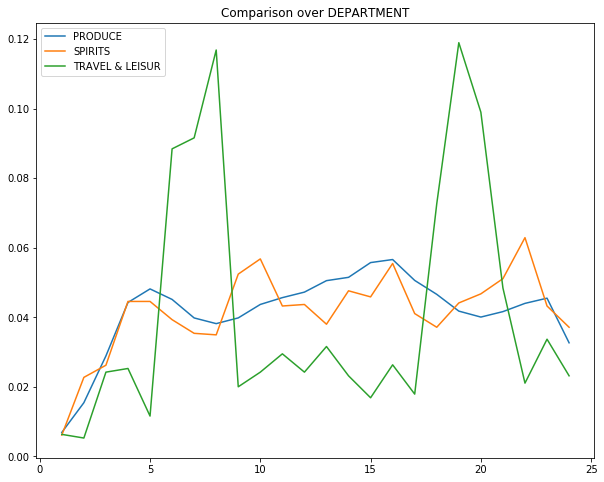

In [116]:
compare_specific_categories(transactions, "DEPARTMENT", ["TRAVEL & LEISUR", "SPIRITS", "PRODUCE"], stat_relative_overall_monthly_quantity)

One can observe that TRAVEL has cyclical spikes in months 6-8 (which coincides with summer) likely due to people going on vacation.

At the same time there is a light drop in SPIRITS and PRODUCE sales which is likely explained by people going on vacation don't do their regular shopping or do it elsewhere (possibly abroad).

## Transaction time of day

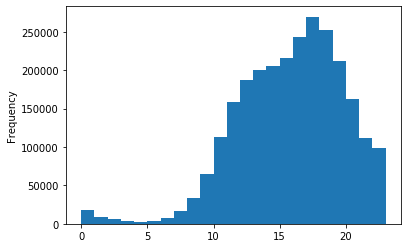

In [121]:
transactions.HOUR.plot.hist(bins=range(0,24))

In [126]:
def times_over_category(data, category_column, show_separate=True, sort=True, minimal_threshold=None):
    
    sums = data.groupby([category_column, "HOUR"])["QUANTITY"].sum()
    overall = data.groupby(category_column)["QUANTITY"].sum()
    if minimal_threshold is not None:
        sums = sums[sums.index.isin(overall[overall > minimal_threshold].index, level=0)]

    values = sums.index.unique(level=0)
    if sort:
        values = sorted(values)
        
    if show_separate:
        for cat in values:
            stat = sums[cat]
            plt.title(cat)
            plt.bar(stat.index, stat)
            plt.show()
    
    # for the second step we normalize the sums
    
    sums = sums / overall

    
    plt.figure(figsize=(10,8))
    for cat in values:
        stat = sums[cat]
        plt.plot(stat.index, stat, label=cat)
    #plt.xlabel("TODO")
    plt.title("Relativized comparison over " + category_column)
    plt.legend()
    plt.show()

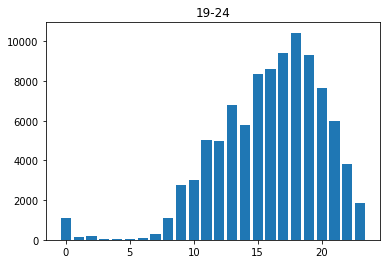

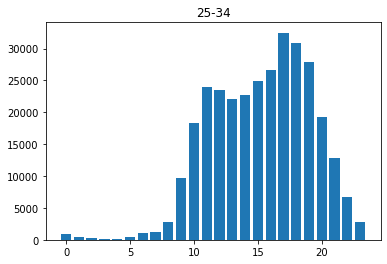

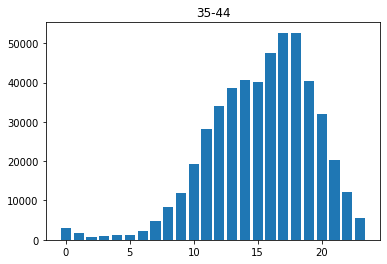

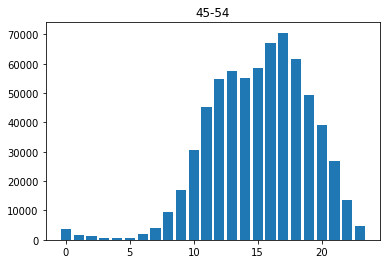

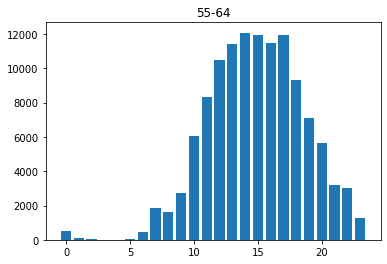

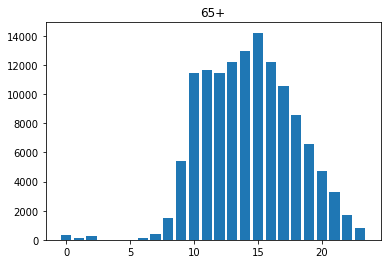

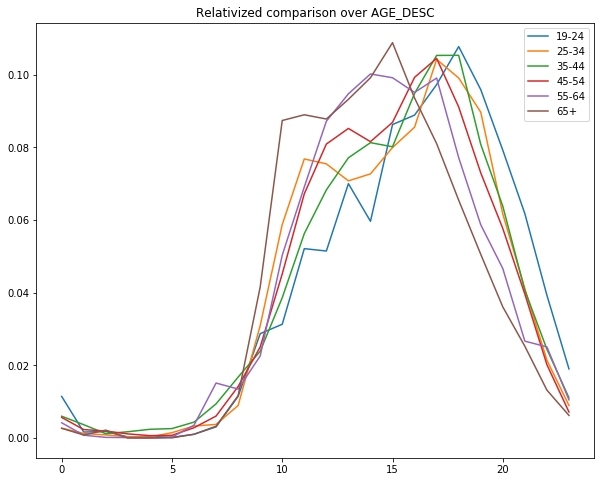

In [128]:
times_over_category(transactions_demographic[(transactions_demographic.SUB_COMMODITY_DESC != "GASOLINE-REG UNLEADED")], "AGE_DESC")


Here we can see that older people tend to do the shopping in the late morning and early afternoon - starting at 9, and with a peak activity at 15.

Adults tend to do most of their shopping later - with most of them shopping around 17-18.

The youngest age group (19-24) tend to do the shopping in the evening - peaking around 18 and being relatively more active in the night.


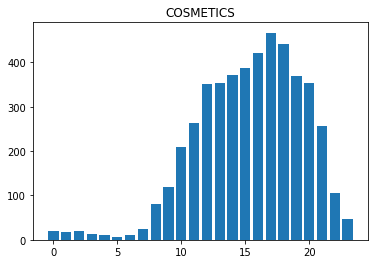

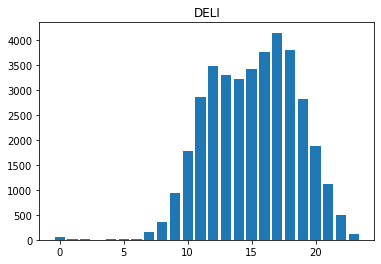

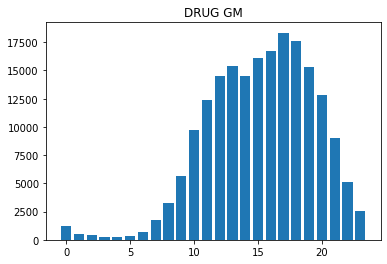

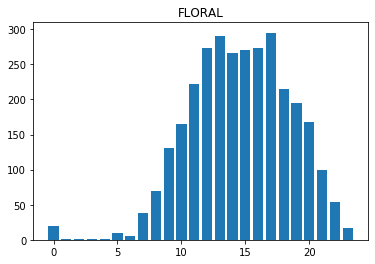

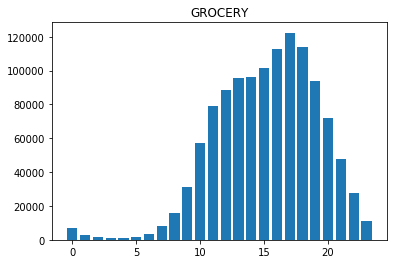

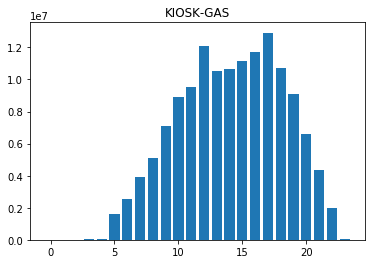

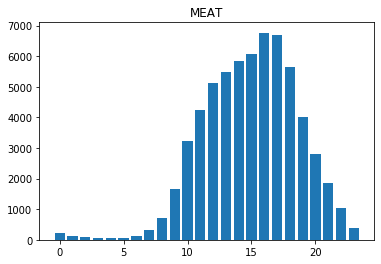

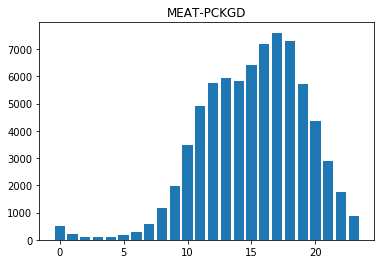

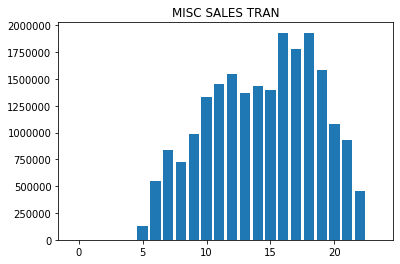

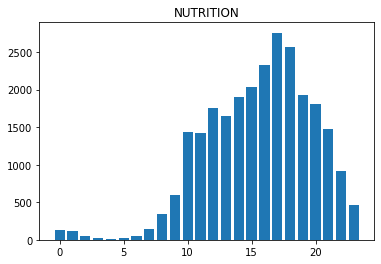

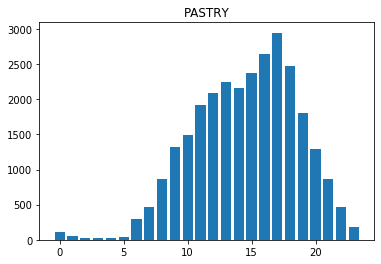

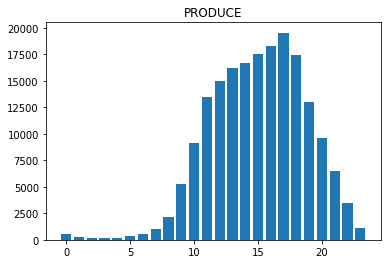

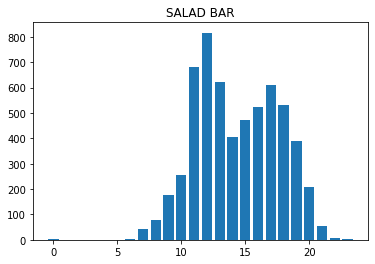

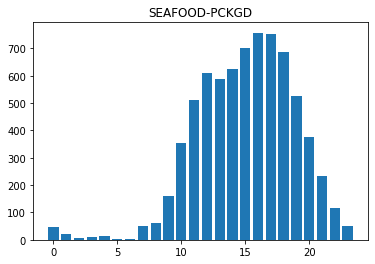

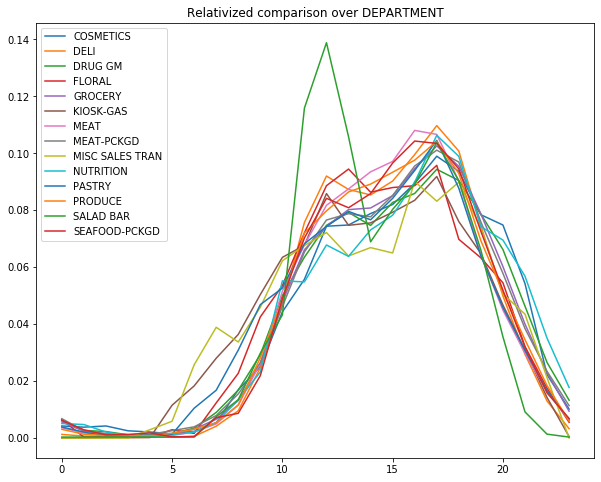

In [130]:
times_over_category(transactions_demographic, "DEPARTMENT", minimal_threshold=3000)

Future work: display bar plot with mean sales overlaid.

From current plots we see that for example the salad bar has two peaks: at 12 and 18. The first one is likely caused by people buying themselves lunch.